In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import *
from encoding_information.plot_utils import *

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-10-28 09:12:56.480098: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-28 09:12:57.047998: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

Opening BSCCM
Opened BSCCM


In [2]:
# load images, extract patches, and compute cov mats
edge_crop = 32
num_images = 10000
num_patches = 10000
channel = 'LED119'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]


In [3]:
patch_sizes = [1, 2, 3, 5, 10, 20, 35, 50]
num_samples = 8
sample_size = 80


# patch_sizes = [1, 5, 10]
# num_samples = 8
# sample_size = 40


# load train and test patches corresponding to the biggest patch size
patches = extract_patches(images, patch_sizes[-1], num_patches=num_patches, seed=0, verbose=True)
test_patches = extract_patches(test_images, patch_sizes[-1], num_patches=num_test_images, seed=0, verbose=True)


test_set_NLL_gp = {}
test_set_NLL_pixel_cnn = {}
mi_estimates_gp = {}
mi_estimates_pixel_cnn = {}
samples = {}
for patch_size in tqdm(patch_sizes):
    # take a random sub crop from the patchs
    subpatches = extract_patches(patches, patch_size, num_patches=num_patches, seed=0, verbose=False)
    test_subpatches = extract_patches(test_patches, patch_size, num_patches=num_test_images, seed=0, verbose=False)

    mi_estimates_gp[patch_size], stationary_gp = estimate_mutual_information(
        subpatches, eigenvalue_floor=eigenvalue_floor, use_iterative_optimization=True, return_entropy_model=True,
        verbose=True)
    test_set_NLL_gp[patch_size] = stationary_gp.compute_negative_log_likelihood(test_subpatches)

    mi_estimates_pixel_cnn[patch_size], pixel_cnn = estimate_mutual_information(
        subpatches, entropy_model='pixelcnn', return_entropy_model=True, verbose=True)
    test_set_NLL_pixel_cnn[patch_size] = pixel_cnn.compute_negative_log_likelihood(test_subpatches)

    samples[patch_size] = {}
    print('generating samples GP')
    samples[patch_size]['GP'] = stationary_gp.generate_samples(num_samples=num_samples, sample_shape=sample_size, seed=None)
    print('generating samples PixelCNN')
    samples[patch_size]['PixelCNN'] = pixel_cnn.generate_samples(num_samples=num_samples, sample_shape=sample_size, seed=None)

print('GP MI estimates', mi_estimates_gp)
print('PixelCNN MI estimates', mi_estimates_pixel_cnn)

  0%|                                                         | 0/8 [00:00<?, ?it/s]2023-10-27 22:09:03.254195: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 6.22



Epoch 1: 100%|████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


Epoch 1: validation NLL: 6.22



Epoch 2: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 211.14it/s]


Epoch 2: validation NLL: 6.22



Epoch 3: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 250.62it/s]


Epoch 3: validation NLL: 6.22



Epoch 4: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 297.85it/s]


Epoch 4: validation NLL: 6.22



Epoch 5: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 180.34it/s]


Epoch 5: validation NLL: 6.22



Epoch 6: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 235.53it/s]


Epoch 6: validation NLL: 6.22



Epoch 7: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 204.35it/s]


Epoch 7: validation NLL: 6.22



Epoch 8: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 257.34it/s]


Epoch 8: validation NLL: 6.22



Epoch 9: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 266.37it/s]


Epoch 9: validation NLL: 6.22



Epoch 10: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 260.11it/s]


Epoch 10: validation NLL: 6.22



Epoch 11: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 268.71it/s]


Epoch 11: validation NLL: 6.22



Epoch 12: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 198.23it/s]


Epoch 12: validation NLL: 6.22



Epoch 13: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 275.27it/s]


Epoch 13: validation NLL: 6.22



Epoch 14: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 297.32it/s]


Epoch 14: validation NLL: 6.22



Epoch 15: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 186.65it/s]


Epoch 15: validation NLL: 6.22



Epoch 16: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 288.98it/s]


Epoch 16: validation NLL: 6.22



Epoch 17: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 293.55it/s]


Epoch 17: validation NLL: 6.22



Epoch 18: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 234.54it/s]


Epoch 18: validation NLL: 6.22



Epoch 19: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 195.80it/s]


Epoch 19: validation NLL: 6.22



precomputing masks and variances: 100%|███████████████| 1/1 [00:00<00:00, 52.55it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████████████| 1/1 [00:00<00:00, 558.35it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 6.303 differential entropy/pixel
Estimated I(Y;X) = 2.792 bits/pixel



precomputing masks and variances: 100%|██████████████| 1/1 [00:00<00:00, 545.57it/s]

evaluating likelihood




computing log likelihoods: 100%|█████████████████████| 1/1 [00:00<00:00, 748.18it/s]


Initial validation NLL: 135.02



Epoch 1: 100%|████████████████████████████████████| 100/100 [00:05<00:00, 18.82it/s]


Epoch 1: validation NLL: 6.31



Epoch 2: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 177.59it/s]


Epoch 2: validation NLL: 6.31



Epoch 3: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 178.73it/s]


Epoch 3: validation NLL: 6.32



Epoch 4: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 180.85it/s]


Epoch 4: validation NLL: 6.32



Epoch 5: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 170.84it/s]


Epoch 5: validation NLL: 6.31



Epoch 6: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 171.15it/s]


Epoch 6: validation NLL: 6.31



Epoch 7: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 167.08it/s]


Epoch 7: validation NLL: 6.32



Epoch 8: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 170.47it/s]


Epoch 8: validation NLL: 6.31



Epoch 9: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 171.89it/s]


Epoch 9: validation NLL: 6.32



Epoch 10: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 168.10it/s]


Epoch 10: validation NLL: 6.32



Epoch 11: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 171.05it/s]


Epoch 11: validation NLL: 6.31



Epoch 12: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 171.02it/s]


Epoch 12: validation NLL: 6.32



Computing loss: 100%|███████████████████████████████| 63/63 [00:03<00:00, 19.08it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 6.305 differential entropy/pixel
Estimated I(Y;X) = 2.794 bits/pixel



Computing loss: 100%|██████████████████████████████| 63/63 [00:00<00:00, 209.48it/s]


generating samples GP



precomputing masks and variances: 100%|█████████████| 80/80 [02:02<00:00,  1.54s/it]


generating stationary gaussian process samples



generating samples: 100%|███████████████████████████| 80/80 [01:59<00:00,  1.49s/it]


generating samples PixelCNN



 12%|█████▋                                       | 1/8 [24:29<2:51:26, 1469.53s/it]

Initial validation NLL: 5.30



Epoch 1: 100%|████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


Epoch 1: validation NLL: 5.30



Epoch 2: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 198.95it/s]


Epoch 2: validation NLL: 5.30



Epoch 3: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 275.02it/s]


Epoch 3: validation NLL: 5.30



Epoch 4: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 251.96it/s]


Epoch 4: validation NLL: 5.30



Epoch 5: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 252.00it/s]


Epoch 5: validation NLL: 5.30



Epoch 6: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 181.40it/s]


Epoch 6: validation NLL: 5.30



precomputing masks and variances: 100%|███████████████| 2/2 [00:00<00:00, 36.08it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████████████| 2/2 [00:00<00:00, 547.81it/s]


Estimated H(Y|X) = 4.366 differential entropy/pixel
Estimated H(Y) (upper bound) = 5.367 differential entropy/pixel
Estimated I(Y;X) = 1.445 bits/pixel



precomputing masks and variances: 100%|██████████████| 2/2 [00:00<00:00, 475.81it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████████████| 2/2 [00:00<00:00, 563.71it/s]


Initial validation NLL: 129.79



Epoch 1: 100%|████████████████████████████████████| 100/100 [00:05<00:00, 17.74it/s]


Epoch 1: validation NLL: 6.05



Epoch 2: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 154.68it/s]


Epoch 2: validation NLL: 5.71



Epoch 3: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 153.45it/s]


Epoch 3: validation NLL: 5.63



Epoch 4: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 152.87it/s]


Epoch 4: validation NLL: 5.61



Epoch 5: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 153.47it/s]


Epoch 5: validation NLL: 5.58



Epoch 6: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 157.17it/s]


Epoch 6: validation NLL: 5.59



Epoch 7: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 155.49it/s]


Epoch 7: validation NLL: 5.60



Epoch 8: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 152.59it/s]


Epoch 8: validation NLL: 5.58



Epoch 9: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 152.67it/s]


Epoch 9: validation NLL: 5.56



Epoch 10: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 151.35it/s]


Epoch 10: validation NLL: 5.63



Epoch 11: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 148.58it/s]


Epoch 11: validation NLL: 5.57



Epoch 12: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 148.64it/s]


Epoch 12: validation NLL: 5.56



Epoch 13: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 153.27it/s]


Epoch 13: validation NLL: 5.55



Epoch 14: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 156.13it/s]


Epoch 14: validation NLL: 5.40



Epoch 15: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 149.67it/s]


Epoch 15: validation NLL: 5.40



Epoch 16: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 148.26it/s]


Epoch 16: validation NLL: 5.42



Epoch 17: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 146.18it/s]


Epoch 17: validation NLL: 5.38



Epoch 18: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 156.19it/s]


Epoch 18: validation NLL: 5.37



Epoch 19: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 153.58it/s]


Epoch 19: validation NLL: 5.38



Epoch 20: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 153.90it/s]


Epoch 20: validation NLL: 5.37



Epoch 21: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 153.41it/s]


Epoch 21: validation NLL: 5.43



Epoch 22: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 153.51it/s]


Epoch 22: validation NLL: 5.37



Epoch 23: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 149.79it/s]


Epoch 23: validation NLL: 5.38



Epoch 24: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 146.72it/s]


Epoch 24: validation NLL: 5.38



Epoch 25: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 145.21it/s]


Epoch 25: validation NLL: 5.43



Epoch 26: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 152.28it/s]


Epoch 26: validation NLL: 5.41



Epoch 27: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 151.39it/s]


Epoch 27: validation NLL: 5.41



Epoch 28: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 144.88it/s]


Epoch 28: validation NLL: 5.40



Epoch 29: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 147.02it/s]


Epoch 29: validation NLL: 5.40



Epoch 30: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 151.66it/s]


Epoch 30: validation NLL: 5.42



Epoch 31: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 148.74it/s]


Epoch 31: validation NLL: 5.38



Epoch 32: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 148.82it/s]


Epoch 32: validation NLL: 5.38



Computing loss: 100%|███████████████████████████████| 63/63 [00:03<00:00, 20.52it/s]


Estimated H(Y|X) = 4.366 differential entropy/pixel
Estimated H(Y) (upper bound) = 5.375 differential entropy/pixel
Estimated I(Y;X) = 1.456 bits/pixel



Computing loss: 100%|██████████████████████████████| 63/63 [00:00<00:00, 253.69it/s]


generating samples GP



precomputing masks and variances: 100%|█████████████| 80/80 [02:10<00:00,  1.63s/it]


generating stationary gaussian process samples



generating samples: 100%|███████████████████████████| 80/80 [01:58<00:00,  1.49s/it]


generating samples PixelCNN



 25%|███████████▎                                 | 2/8 [49:27<2:28:38, 1486.47s/it]

Initial validation NLL: 5.00



Epoch 1: 100%|████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


Epoch 1: validation NLL: 5.00



Epoch 2: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 135.93it/s]


Epoch 2: validation NLL: 5.00



Epoch 3: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 183.60it/s]


Epoch 3: validation NLL: 5.00



Epoch 4: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 178.18it/s]


Epoch 4: validation NLL: 5.01



Epoch 5: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 168.57it/s]


Epoch 5: validation NLL: 5.01



Epoch 6: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 149.88it/s]


Epoch 6: validation NLL: 5.00



Epoch 7: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 164.04it/s]


Epoch 7: validation NLL: 5.00



Epoch 8: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 186.58it/s]


Epoch 8: validation NLL: 5.01



precomputing masks and variances: 100%|███████████████| 3/3 [00:00<00:00, 44.88it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████████████| 3/3 [00:00<00:00, 372.45it/s]


Estimated H(Y|X) = 4.366 differential entropy/pixel
Estimated H(Y) (upper bound) = 5.017 differential entropy/pixel
Estimated I(Y;X) = 0.940 bits/pixel



precomputing masks and variances: 100%|██████████████| 3/3 [00:00<00:00, 409.12it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████████████| 3/3 [00:00<00:00, 383.70it/s]


Initial validation NLL: 124.49



Epoch 1: 100%|████████████████████████████████████| 100/100 [00:06<00:00, 16.47it/s]


Epoch 1: validation NLL: 5.89



Epoch 2: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 153.34it/s]


Epoch 2: validation NLL: 5.36



Epoch 3: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 154.98it/s]


Epoch 3: validation NLL: 5.17



Epoch 4: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 151.77it/s]


Epoch 4: validation NLL: 5.07



Epoch 5: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 151.30it/s]


Epoch 5: validation NLL: 5.09



Epoch 6: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 152.60it/s]


Epoch 6: validation NLL: 5.06



Epoch 7: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 151.37it/s]


Epoch 7: validation NLL: 5.04



Epoch 8: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 151.72it/s]


Epoch 8: validation NLL: 5.06



Epoch 9: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 151.30it/s]


Epoch 9: validation NLL: 5.02



Epoch 10: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 150.49it/s]


Epoch 10: validation NLL: 5.06



Epoch 11: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 153.46it/s]


Epoch 11: validation NLL: 5.03



Epoch 12: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 151.82it/s]


Epoch 12: validation NLL: 5.08



Epoch 13: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 149.97it/s]


Epoch 13: validation NLL: 5.04



Epoch 14: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 150.49it/s]


Epoch 14: validation NLL: 5.05



Epoch 15: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 151.97it/s]


Epoch 15: validation NLL: 5.04



Epoch 16: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 151.42it/s]


Epoch 16: validation NLL: 5.06



Epoch 17: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 141.95it/s]


Epoch 17: validation NLL: 5.02



Epoch 18: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 137.99it/s]


Epoch 18: validation NLL: 5.06



Epoch 19: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 148.66it/s]


Epoch 19: validation NLL: 5.01



Epoch 20: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 145.36it/s]


Epoch 20: validation NLL: 5.03



Epoch 21: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 145.29it/s]


Epoch 21: validation NLL: 5.04



Epoch 22: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 147.38it/s]


Epoch 22: validation NLL: 5.08



Epoch 23: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 152.59it/s]


Epoch 23: validation NLL: 5.01



Epoch 24: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 149.96it/s]


Epoch 24: validation NLL: 5.04



Epoch 25: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 152.37it/s]


Epoch 25: validation NLL: 5.02



Epoch 26: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 148.72it/s]


Epoch 26: validation NLL: 5.03



Epoch 27: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 141.10it/s]


Epoch 27: validation NLL: 5.02



Epoch 28: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 149.93it/s]


Epoch 28: validation NLL: 5.03



Epoch 29: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 152.46it/s]


Epoch 29: validation NLL: 5.03



Computing loss:   0%|                                        | 0/63 [00:00<?, ?it/s]2023-10-27 22:59:23.841686: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-27 22:59:23.841721: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,3,3]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

Computing loss:  76%|███████████████████████▌       | 48/63 [00:01<00:00, 45.47it/s]2023-10-27 22:59:25.558870: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-27 22:59:25.558907: W external/xla/xla

Estimated H(Y|X) = 4.366 differential entropy/pixel
Estimated H(Y) (upper bound) = 5.024 differential entropy/pixel
Estimated I(Y;X) = 0.950 bits/pixel



Computing loss: 100%|██████████████████████████████| 63/63 [00:00<00:00, 224.80it/s]


generating samples GP



precomputing masks and variances: 100%|█████████████| 80/80 [02:11<00:00,  1.64s/it]


generating stationary gaussian process samples



generating samples: 100%|███████████████████████████| 80/80 [01:59<00:00,  1.49s/it]


generating samples PixelCNN



Generating PixelCNN samples:   0%|                           | 0/80 [00:00<?, ?it/s]2023-10-27 23:03:38.060773: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-27 23:03:38.060810: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,3,3]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

 38%|████████████████▏                          | 3/8 [1:14:34<2:04:38, 1495.60s/it]

Initial validation NLL: 4.77



Epoch 1: 100%|████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 1: validation NLL: 4.77



Epoch 2: 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 87.38it/s]


Epoch 2: validation NLL: 4.77



Epoch 3: 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 96.15it/s]


Epoch 3: validation NLL: 4.77



Epoch 4: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 102.43it/s]


Epoch 4: validation NLL: 4.77



Epoch 5: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 102.23it/s]


Epoch 5: validation NLL: 4.77



Epoch 6: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 108.03it/s]


Epoch 6: validation NLL: 4.77



Epoch 7: 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 95.15it/s]


Epoch 7: validation NLL: 4.77



Epoch 8: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 106.90it/s]


Epoch 8: validation NLL: 4.77



Epoch 9: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 103.47it/s]


Epoch 9: validation NLL: 4.77



Epoch 10: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 114.14it/s]


Epoch 10: validation NLL: 4.77



Epoch 11: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 98.22it/s]


Epoch 11: validation NLL: 4.77



Epoch 12: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 106.74it/s]


Epoch 12: validation NLL: 4.77



Epoch 13: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 102.64it/s]


Epoch 13: validation NLL: 4.77



precomputing masks and variances: 100%|███████████████| 5/5 [00:00<00:00, 60.67it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████████████| 5/5 [00:00<00:00, 271.58it/s]


Estimated H(Y|X) = 4.365 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.741 differential entropy/pixel
Estimated I(Y;X) = 0.543 bits/pixel



precomputing masks and variances: 100%|██████████████| 5/5 [00:00<00:00, 285.61it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████████████| 5/5 [00:00<00:00, 278.73it/s]


Initial validation NLL: 116.78



Epoch 1: 100%|████████████████████████████████████| 100/100 [00:06<00:00, 16.20it/s]


Epoch 1: validation NLL: 5.54



Epoch 2: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 114.49it/s]


Epoch 2: validation NLL: 4.90



Epoch 3: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 133.45it/s]


Epoch 3: validation NLL: 4.90



Epoch 4: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 136.90it/s]


Epoch 4: validation NLL: 4.83



Epoch 5: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 128.76it/s]


Epoch 5: validation NLL: 4.79



Epoch 6: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 133.39it/s]


Epoch 6: validation NLL: 4.77



Epoch 7: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 134.22it/s]


Epoch 7: validation NLL: 4.79



Epoch 8: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 134.16it/s]


Epoch 8: validation NLL: 4.78



Epoch 9: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 134.91it/s]


Epoch 9: validation NLL: 4.79



Epoch 10: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 130.99it/s]


Epoch 10: validation NLL: 4.76



Epoch 11: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 133.91it/s]


Epoch 11: validation NLL: 4.76



Epoch 12: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 135.27it/s]


Epoch 12: validation NLL: 4.77



Epoch 13: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 128.88it/s]


Epoch 13: validation NLL: 4.76



Epoch 14: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 133.41it/s]


Epoch 14: validation NLL: 4.80



Epoch 15: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 134.43it/s]


Epoch 15: validation NLL: 4.79



Epoch 16: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 136.12it/s]


Epoch 16: validation NLL: 4.77



Epoch 17: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 133.58it/s]


Epoch 17: validation NLL: 4.74



Epoch 18: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 129.95it/s]


Epoch 18: validation NLL: 4.80



Epoch 19: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 134.72it/s]


Epoch 19: validation NLL: 4.76



Epoch 20: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 133.05it/s]


Epoch 20: validation NLL: 4.79



Epoch 21: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 131.06it/s]


Epoch 21: validation NLL: 4.75



Epoch 22: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 130.96it/s]


Epoch 22: validation NLL: 4.79



Epoch 23: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 134.30it/s]


Epoch 23: validation NLL: 4.79



Epoch 24: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 135.13it/s]


Epoch 24: validation NLL: 4.78



Epoch 25: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 133.40it/s]


Epoch 25: validation NLL: 4.75



Epoch 26: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 129.31it/s]


Epoch 26: validation NLL: 4.74



Epoch 27: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 132.92it/s]


Epoch 27: validation NLL: 4.74



Epoch 28: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 133.71it/s]


Epoch 28: validation NLL: 4.82



Epoch 29: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 133.05it/s]


Epoch 29: validation NLL: 4.76



Epoch 30: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 134.00it/s]


Epoch 30: validation NLL: 4.76



Epoch 31: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 128.00it/s]


Epoch 31: validation NLL: 4.74



Epoch 32: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 133.47it/s]


Epoch 32: validation NLL: 4.76



Epoch 33: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 134.12it/s]


Epoch 33: validation NLL: 4.75



Epoch 34: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 133.84it/s]


Epoch 34: validation NLL: 4.75



Epoch 35: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 134.15it/s]


Epoch 35: validation NLL: 4.75



Epoch 36: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 131.14it/s]


Epoch 36: validation NLL: 4.76



Computing loss:   0%|                                        | 0/63 [00:00<?, ?it/s]2023-10-27 23:24:39.043396: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-27 23:24:39.043436: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,5,5]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

Computing loss:  70%|█████████████████████▋         | 44/63 [00:01<00:00, 39.76it/s]2023-10-27 23:24:40.735151: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-27 23:24:40.735200: W external/xla/xla

Estimated H(Y|X) = 4.365 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.743 differential entropy/pixel
Estimated I(Y;X) = 0.546 bits/pixel



Computing loss: 100%|██████████████████████████████| 63/63 [00:00<00:00, 216.91it/s]


generating samples GP



precomputing masks and variances: 100%|█████████████| 80/80 [02:15<00:00,  1.69s/it]


generating stationary gaussian process samples



generating samples: 100%|███████████████████████████| 80/80 [01:58<00:00,  1.48s/it]


generating samples PixelCNN



Generating PixelCNN samples:   0%|                           | 0/80 [00:00<?, ?it/s]2023-10-27 23:28:56.290938: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-27 23:28:56.290976: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,5,5]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

 50%|█████████████████████▌                     | 4/8 [1:40:03<1:40:34, 1508.70s/it]

Initial validation NLL: 4.56



Epoch 1: 100%|████████████████████████████████████████| 1/1 [00:03<00:00,  3.86s/it]


Epoch 1: validation NLL: 4.56



Epoch 2: 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 40.91it/s]


Epoch 2: validation NLL: 4.56



Epoch 3: 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 48.79it/s]


Epoch 3: validation NLL: 4.56



Epoch 4: 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 50.29it/s]


Epoch 4: validation NLL: 4.56



Epoch 5: 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 48.73it/s]


Epoch 5: validation NLL: 4.56



Epoch 6: 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 48.47it/s]


Epoch 6: validation NLL: 4.56



Epoch 7: 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 49.16it/s]


Epoch 7: validation NLL: 4.56



Epoch 8: 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 43.67it/s]


Epoch 8: validation NLL: 4.56



Epoch 9: 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 48.16it/s]


Epoch 9: validation NLL: 4.56



Epoch 10: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 48.00it/s]


Epoch 10: validation NLL: 4.56



Epoch 11: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 48.44it/s]


Epoch 11: validation NLL: 4.56



Epoch 12: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 48.13it/s]


Epoch 12: validation NLL: 4.56



Epoch 13: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 39.75it/s]


Epoch 13: validation NLL: 4.56



precomputing masks and variances: 100%|█████████████| 10/10 [00:00<00:00, 66.51it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 10/10 [00:00<00:00, 182.29it/s]


Estimated H(Y|X) = 4.369 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.554 differential entropy/pixel
Estimated I(Y;X) = 0.267 bits/pixel



precomputing masks and variances: 100%|████████████| 10/10 [00:00<00:00, 215.55it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 10/10 [00:00<00:00, 186.39it/s]


Initial validation NLL: 121.85



Epoch 1: 100%|████████████████████████████████████| 100/100 [00:06<00:00, 15.92it/s]


Epoch 1: validation NLL: 5.30



Epoch 2: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 117.30it/s]


Epoch 2: validation NLL: 4.82



Epoch 3: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 116.69it/s]


Epoch 3: validation NLL: 4.73



Epoch 4: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 118.03it/s]


Epoch 4: validation NLL: 4.63



Epoch 5: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 115.21it/s]


Epoch 5: validation NLL: 4.62



Epoch 6: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 118.22it/s]


Epoch 6: validation NLL: 4.71



Epoch 7: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 116.81it/s]


Epoch 7: validation NLL: 4.60



Epoch 8: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 115.23it/s]


Epoch 8: validation NLL: 4.55



Epoch 9: 100%|███████████████████████████████████| 100/100 [00:00<00:00, 116.61it/s]


Epoch 9: validation NLL: 4.54



Epoch 10: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 114.76it/s]


Epoch 10: validation NLL: 4.54



Epoch 11: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 116.06it/s]


Epoch 11: validation NLL: 4.57



Epoch 12: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 115.40it/s]


Epoch 12: validation NLL: 4.55



Epoch 13: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 114.95it/s]


Epoch 13: validation NLL: 4.54



Epoch 14: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 116.12it/s]


Epoch 14: validation NLL: 4.54



Epoch 15: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 112.02it/s]


Epoch 15: validation NLL: 4.79



Epoch 16: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 116.67it/s]


Epoch 16: validation NLL: 4.53



Epoch 17: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 115.14it/s]


Epoch 17: validation NLL: 4.53



Epoch 18: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 117.24it/s]


Epoch 18: validation NLL: 4.55



Epoch 19: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 116.14it/s]


Epoch 19: validation NLL: 4.52



Epoch 20: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 115.95it/s]


Epoch 20: validation NLL: 4.54



Epoch 21: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 117.86it/s]


Epoch 21: validation NLL: 4.56



Epoch 22: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 114.77it/s]


Epoch 22: validation NLL: 4.53



Epoch 23: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 119.26it/s]


Epoch 23: validation NLL: 4.53



Epoch 24: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 114.51it/s]


Epoch 24: validation NLL: 4.60



Epoch 25: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 115.36it/s]


Epoch 25: validation NLL: 4.52



Epoch 26: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 116.56it/s]


Epoch 26: validation NLL: 4.56



Epoch 27: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 115.51it/s]


Epoch 27: validation NLL: 4.53



Epoch 28: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 116.54it/s]


Epoch 28: validation NLL: 4.53



Epoch 29: 100%|██████████████████████████████████| 100/100 [00:00<00:00, 115.23it/s]


Epoch 29: validation NLL: 4.52



Computing loss:   0%|                                        | 0/63 [00:00<?, ?it/s]2023-10-27 23:50:12.745197: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-27 23:50:12.745227: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,10,10]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,10,10]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

Computing loss:  76%|███████████████████████▌       | 48/63 [00:02<00:00, 45.61it/s]2023-10-27 23:50:14.700192: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-27 23:50:14.700220: W external/xla

Estimated H(Y|X) = 4.369 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.521 differential entropy/pixel
Estimated I(Y;X) = 0.220 bits/pixel



Computing loss: 100%|██████████████████████████████| 63/63 [00:00<00:00, 110.24it/s]


generating samples GP



precomputing masks and variances: 100%|█████████████| 80/80 [02:25<00:00,  1.81s/it]


generating stationary gaussian process samples



generating samples: 100%|███████████████████████████| 80/80 [02:00<00:00,  1.51s/it]


generating samples PixelCNN



Generating PixelCNN samples:   0%|                           | 0/80 [00:00<?, ?it/s]2023-10-27 23:54:42.900371: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-27 23:54:42.900408: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,10,10]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,10,10]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

 62%|██████████████████████████▉                | 5/8 [2:06:51<1:17:13, 1544.62s/it]

Initial validation NLL: 4.47



Epoch 1: 100%|████████████████████████████████████████| 1/1 [00:08<00:00,  8.69s/it]


Epoch 1: validation NLL: 4.47



Epoch 2: 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 13.83it/s]


Epoch 2: validation NLL: 4.47



Epoch 3: 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 3: validation NLL: 4.47



Epoch 4: 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 13.99it/s]


Epoch 4: validation NLL: 4.47



Epoch 5: 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 13.98it/s]


Epoch 5: validation NLL: 4.47



Epoch 6: 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 13.91it/s]


Epoch 6: validation NLL: 4.47



Epoch 7: 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 13.93it/s]


Epoch 7: validation NLL: 4.47



precomputing masks and variances: 100%|█████████████| 20/20 [00:00<00:00, 59.72it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 20/20 [00:00<00:00, 93.25it/s]


Estimated H(Y|X) = 4.373 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.459 differential entropy/pixel
Estimated I(Y;X) = 0.124 bits/pixel



precomputing masks and variances: 100%|█████████████| 20/20 [00:00<00:00, 84.65it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 20/20 [00:00<00:00, 83.15it/s]


Initial validation NLL: 118.35



Epoch 1: 100%|████████████████████████████████████| 100/100 [00:09<00:00, 10.73it/s]


Epoch 1: validation NLL: 5.06



Epoch 2: 100%|████████████████████████████████████| 100/100 [00:01<00:00, 51.69it/s]


Epoch 2: validation NLL: 4.77



Epoch 3: 100%|████████████████████████████████████| 100/100 [00:01<00:00, 50.11it/s]


Epoch 3: validation NLL: 4.56



Epoch 4: 100%|████████████████████████████████████| 100/100 [00:01<00:00, 50.51it/s]


Epoch 4: validation NLL: 4.52



Epoch 5: 100%|████████████████████████████████████| 100/100 [00:01<00:00, 51.79it/s]


Epoch 5: validation NLL: 4.59



Epoch 6: 100%|████████████████████████████████████| 100/100 [00:01<00:00, 51.04it/s]


Epoch 6: validation NLL: 4.46



Epoch 7: 100%|████████████████████████████████████| 100/100 [00:01<00:00, 50.93it/s]


Epoch 7: validation NLL: 4.47



Epoch 8: 100%|████████████████████████████████████| 100/100 [00:01<00:00, 50.99it/s]


Epoch 8: validation NLL: 4.46



Epoch 9: 100%|████████████████████████████████████| 100/100 [00:02<00:00, 48.34it/s]


Epoch 9: validation NLL: 4.45



Epoch 10: 100%|███████████████████████████████████| 100/100 [00:01<00:00, 50.37it/s]


Epoch 10: validation NLL: 4.46



Epoch 11: 100%|███████████████████████████████████| 100/100 [00:01<00:00, 51.18it/s]


Epoch 11: validation NLL: 4.44



Epoch 12: 100%|███████████████████████████████████| 100/100 [00:01<00:00, 50.14it/s]


Epoch 12: validation NLL: 4.42



Epoch 13: 100%|███████████████████████████████████| 100/100 [00:01<00:00, 51.69it/s]


Epoch 13: validation NLL: 4.42



Epoch 14: 100%|███████████████████████████████████| 100/100 [00:01<00:00, 50.05it/s]


Epoch 14: validation NLL: 4.47



Epoch 15: 100%|███████████████████████████████████| 100/100 [00:01<00:00, 50.44it/s]


Epoch 15: validation NLL: 4.50



Epoch 16: 100%|███████████████████████████████████| 100/100 [00:02<00:00, 49.49it/s]


Epoch 16: validation NLL: 4.41



Epoch 17: 100%|███████████████████████████████████| 100/100 [00:02<00:00, 49.83it/s]


Epoch 17: validation NLL: 4.41



Epoch 18: 100%|███████████████████████████████████| 100/100 [00:01<00:00, 50.07it/s]


Epoch 18: validation NLL: 4.42



Epoch 19: 100%|███████████████████████████████████| 100/100 [00:01<00:00, 51.35it/s]


Epoch 19: validation NLL: 4.53



Epoch 20: 100%|███████████████████████████████████| 100/100 [00:02<00:00, 50.00it/s]


Epoch 20: validation NLL: 4.41



Epoch 21: 100%|███████████████████████████████████| 100/100 [00:02<00:00, 47.61it/s]


Epoch 21: validation NLL: 4.42



Epoch 22: 100%|███████████████████████████████████| 100/100 [00:02<00:00, 47.49it/s]


Epoch 22: validation NLL: 4.41



Epoch 23: 100%|███████████████████████████████████| 100/100 [00:02<00:00, 47.16it/s]


Epoch 23: validation NLL: 4.41



Epoch 24: 100%|███████████████████████████████████| 100/100 [00:02<00:00, 47.36it/s]


Epoch 24: validation NLL: 4.45



Epoch 25: 100%|███████████████████████████████████| 100/100 [00:02<00:00, 47.62it/s]


Epoch 25: validation NLL: 5.75



Epoch 26: 100%|███████████████████████████████████| 100/100 [00:02<00:00, 46.78it/s]


Epoch 26: validation NLL: 5.74



Epoch 27: 100%|███████████████████████████████████| 100/100 [00:02<00:00, 48.68it/s]


Epoch 27: validation NLL: 5.74



Epoch 28: 100%|███████████████████████████████████| 100/100 [00:02<00:00, 48.30it/s]


Epoch 28: validation NLL: 5.74



Epoch 29: 100%|███████████████████████████████████| 100/100 [00:02<00:00, 47.61it/s]


Epoch 29: validation NLL: 5.74



Epoch 30: 100%|███████████████████████████████████| 100/100 [00:02<00:00, 48.06it/s]


Epoch 30: validation NLL: 5.73



Computing loss:   0%|                                        | 0/63 [00:00<?, ?it/s]2023-10-28 00:18:07.509892: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-28 00:18:07.509922: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,20,20]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,20,20]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

Computing loss:  84%|██████████████████████████     | 53/63 [00:03<00:00, 36.15it/s]2023-10-28 00:18:10.995113: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-28 00:18:10.995142: W external/xla

Estimated H(Y|X) = 4.373 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.405 differential entropy/pixel
Estimated I(Y;X) = 0.046 bits/pixel



Computing loss: 100%|███████████████████████████████| 63/63 [00:01<00:00, 38.60it/s]


generating samples GP



precomputing masks and variances: 100%|█████████████| 80/80 [03:04<00:00,  2.31s/it]


generating stationary gaussian process samples



generating samples: 100%|███████████████████████████| 80/80 [01:59<00:00,  1.49s/it]


generating samples PixelCNN



 75%|█████████████████████████████████▊           | 6/8 [2:39:37<56:15, 1687.87s/it]

Initial validation NLL: 414.64



Epoch 1: 100%|████████████████████████████████████████| 1/1 [00:30<00:00, 30.19s/it]


Epoch 1: validation NLL: 4.48



Epoch 2: 100%|████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch 2: validation NLL: 4.46



Epoch 3: 100%|████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch 3: validation NLL: 4.45



Epoch 4: 100%|████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch 4: validation NLL: 4.45



Epoch 5: 100%|████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 5: validation NLL: 4.45



Epoch 6: 100%|████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch 6: validation NLL: 4.45



Epoch 7: 100%|████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch 7: validation NLL: 4.45



Epoch 8: 100%|████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch 8: validation NLL: 4.44



Epoch 9: 100%|████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch 9: validation NLL: 4.44



Epoch 10: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 10: validation NLL: 4.44



Epoch 11: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch 11: validation NLL: 4.44



Epoch 12: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch 12: validation NLL: 4.44



Epoch 13: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch 13: validation NLL: 4.44



Epoch 14: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch 14: validation NLL: 4.44



Epoch 15: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 15: validation NLL: 4.44



Epoch 16: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 16: validation NLL: 4.44



Epoch 17: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 17: validation NLL: 4.44



Epoch 18: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 18: validation NLL: 4.44



Epoch 19: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 19: validation NLL: 4.44



Epoch 20: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 20: validation NLL: 4.44



Epoch 21: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch 21: validation NLL: 4.44



Epoch 22: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 22: validation NLL: 4.44



Epoch 23: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 23: validation NLL: 4.44



Epoch 24: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 24: validation NLL: 4.44



Epoch 25: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch 25: validation NLL: 4.44



Epoch 26: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 26: validation NLL: 4.44



Epoch 27: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch 27: validation NLL: 4.44



Epoch 28: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 28: validation NLL: 4.44



Epoch 29: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 29: validation NLL: 4.44



Epoch 30: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 30: validation NLL: 4.44



Epoch 31: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch 31: validation NLL: 4.44



Epoch 32: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch 32: validation NLL: 4.44



Epoch 33: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 33: validation NLL: 4.44



Epoch 34: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch 34: validation NLL: 4.44



precomputing masks and variances: 100%|█████████████| 35/35 [00:00<00:00, 40.14it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 35/35 [00:00<00:00, 58.05it/s]


Estimated H(Y|X) = 4.372 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.439 differential entropy/pixel
Estimated I(Y;X) = 0.097 bits/pixel



precomputing masks and variances: 100%|█████████████| 35/35 [00:00<00:00, 52.33it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 35/35 [00:00<00:00, 57.77it/s]


Initial validation NLL: 113.76



Epoch 1: 100%|████████████████████████████████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 1: validation NLL: 5.06



Epoch 2: 100%|████████████████████████████████████| 100/100 [00:04<00:00, 22.01it/s]


Epoch 2: validation NLL: 4.59



Epoch 3: 100%|████████████████████████████████████| 100/100 [00:04<00:00, 22.75it/s]


Epoch 3: validation NLL: 4.55



Epoch 4: 100%|████████████████████████████████████| 100/100 [00:04<00:00, 22.70it/s]


Epoch 4: validation NLL: 4.71



Epoch 5: 100%|████████████████████████████████████| 100/100 [00:04<00:00, 22.67it/s]


Epoch 5: validation NLL: 4.49



Epoch 6: 100%|████████████████████████████████████| 100/100 [00:04<00:00, 22.53it/s]


Epoch 6: validation NLL: 4.42



Epoch 7: 100%|████████████████████████████████████| 100/100 [00:04<00:00, 22.68it/s]


Epoch 7: validation NLL: 4.52



Epoch 8: 100%|████████████████████████████████████| 100/100 [00:04<00:00, 22.72it/s]


Epoch 8: validation NLL: 4.40



Epoch 9: 100%|████████████████████████████████████| 100/100 [00:04<00:00, 22.71it/s]


Epoch 9: validation NLL: 4.39



Epoch 10: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.38it/s]


Epoch 10: validation NLL: 4.38



Epoch 11: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.39it/s]


Epoch 11: validation NLL: 4.41



Epoch 12: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.65it/s]


Epoch 12: validation NLL: 4.38



Epoch 13: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.63it/s]


Epoch 13: validation NLL: 4.43



Epoch 14: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.59it/s]


Epoch 14: validation NLL: 4.37



Epoch 15: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.74it/s]


Epoch 15: validation NLL: 4.37



Epoch 16: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.52it/s]


Epoch 16: validation NLL: 4.43



Epoch 17: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.49it/s]


Epoch 17: validation NLL: 4.37



Epoch 18: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.45it/s]


Epoch 18: validation NLL: 4.38



Epoch 19: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.54it/s]


Epoch 19: validation NLL: 4.40



Epoch 20: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.47it/s]


Epoch 20: validation NLL: 4.56



Epoch 21: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.44it/s]


Epoch 21: validation NLL: 4.36



Epoch 22: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.35it/s]


Epoch 22: validation NLL: 4.36



Epoch 23: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.51it/s]


Epoch 23: validation NLL: 4.44



Epoch 24: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.34it/s]


Epoch 24: validation NLL: 4.35



Epoch 25: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.53it/s]


Epoch 25: validation NLL: 4.37



Epoch 26: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.78it/s]


Epoch 26: validation NLL: 4.37



Epoch 27: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.43it/s]


Epoch 27: validation NLL: 4.35



Epoch 28: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.66it/s]


Epoch 28: validation NLL: 4.35



Epoch 29: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.55it/s]


Epoch 29: validation NLL: 4.39



Epoch 30: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.60it/s]


Epoch 30: validation NLL: 4.36



Epoch 31: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.42it/s]


Epoch 31: validation NLL: 4.36



Epoch 32: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.38it/s]


Epoch 32: validation NLL: 4.36



Epoch 33: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.30it/s]


Epoch 33: validation NLL: 4.36



Epoch 34: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.47it/s]


Epoch 34: validation NLL: 4.35



Epoch 35: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.18it/s]


Epoch 35: validation NLL: 4.37



Epoch 36: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.52it/s]


Epoch 36: validation NLL: 4.37



Epoch 37: 100%|███████████████████████████████████| 100/100 [00:04<00:00, 22.15it/s]


Epoch 37: validation NLL: 4.36



Computing loss:   0%|                                        | 0/63 [00:00<?, ?it/s]2023-10-28 00:54:41.578305: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-28 00:54:41.578331: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,35,35]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,35,35]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-28 00:54:43.541903: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-28 00:54:43.541929: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,35,35]{3,2,1,0}, u8[

Estimated H(Y|X) = 4.372 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.356 differential entropy/pixel
Estimated I(Y;X) = -0.022 bits/pixel



Computing loss: 100%|███████████████████████████████| 63/63 [00:04<00:00, 14.24it/s]


generating samples GP



precomputing masks and variances: 100%|█████████████| 80/80 [04:21<00:00,  3.27s/it]


generating stationary gaussian process samples



generating samples: 100%|███████████████████████████| 80/80 [01:49<00:00,  1.36s/it]


generating samples PixelCNN



Generating PixelCNN samples:   0%|                           | 0/80 [00:00<?, ?it/s]2023-10-28 01:01:10.053304: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-28 01:01:10.053338: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,35,35]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,35,35]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

 88%|███████████████████████████████████████▍     | 7/8 [3:22:55<33:05, 1985.57s/it]

Initial validation NLL: 5433.74



Epoch 1: 100%|████████████████████████████████████████| 1/1 [01:28<00:00, 88.85s/it]


Epoch 1: validation NLL: 456.47



Epoch 2: 100%|████████████████████████████████████████| 1/1 [00:03<00:00,  3.14s/it]


Epoch 2: validation NLL: 4.45



Epoch 3: 100%|████████████████████████████████████████| 1/1 [00:03<00:00,  3.16s/it]


Epoch 3: validation NLL: 4.43



Epoch 4: 100%|████████████████████████████████████████| 1/1 [00:03<00:00,  3.16s/it]


Epoch 4: validation NLL: 4.43



Epoch 5: 100%|████████████████████████████████████████| 1/1 [00:03<00:00,  3.16s/it]


Epoch 5: validation NLL: 4.43



Epoch 6: 100%|████████████████████████████████████████| 1/1 [00:03<00:00,  3.16s/it]


Epoch 6: validation NLL: 4.43



Epoch 7: 100%|████████████████████████████████████████| 1/1 [00:03<00:00,  3.19s/it]


Epoch 7: validation NLL: 4.43



Epoch 8: 100%|████████████████████████████████████████| 1/1 [00:03<00:00,  3.20s/it]


Epoch 8: validation NLL: 4.43



Epoch 9: 100%|████████████████████████████████████████| 1/1 [00:03<00:00,  3.20s/it]


Epoch 9: validation NLL: 4.43



Epoch 10: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.20s/it]


Epoch 10: validation NLL: 4.43



Epoch 11: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.20s/it]


Epoch 11: validation NLL: 4.43



precomputing masks and variances: 100%|█████████████| 50/50 [00:01<00:00, 33.14it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 50/50 [00:01<00:00, 36.95it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.424 differential entropy/pixel
Estimated I(Y;X) = 0.082 bits/pixel



precomputing masks and variances: 100%|█████████████| 50/50 [00:01<00:00, 35.64it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 50/50 [00:01<00:00, 37.22it/s]


Initial validation NLL: 119.97



Epoch 1: 100%|████████████████████████████████████| 100/100 [00:23<00:00,  4.17it/s]


Epoch 1: validation NLL: 5.05



Epoch 2: 100%|████████████████████████████████████| 100/100 [00:08<00:00, 11.88it/s]


Epoch 2: validation NLL: 4.72



Epoch 3: 100%|████████████████████████████████████| 100/100 [00:07<00:00, 12.66it/s]


Epoch 3: validation NLL: 4.50



Epoch 4: 100%|████████████████████████████████████| 100/100 [00:08<00:00, 12.50it/s]


Epoch 4: validation NLL: 4.61



Epoch 5: 100%|████████████████████████████████████| 100/100 [00:08<00:00, 12.39it/s]


Epoch 5: validation NLL: 4.50



Epoch 6: 100%|████████████████████████████████████| 100/100 [00:08<00:00, 12.42it/s]


Epoch 6: validation NLL: 4.40



Epoch 7: 100%|████████████████████████████████████| 100/100 [00:08<00:00, 12.40it/s]


Epoch 7: validation NLL: 4.39



Epoch 8: 100%|████████████████████████████████████| 100/100 [00:08<00:00, 12.45it/s]


Epoch 8: validation NLL: 4.39



Epoch 9: 100%|████████████████████████████████████| 100/100 [00:08<00:00, 12.39it/s]


Epoch 9: validation NLL: 4.36



Epoch 10: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.37it/s]


Epoch 10: validation NLL: 4.35



Epoch 11: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.38it/s]


Epoch 11: validation NLL: 4.52



Epoch 12: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.41it/s]


Epoch 12: validation NLL: 4.39



Epoch 13: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.36it/s]


Epoch 13: validation NLL: 4.34



Epoch 14: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.29it/s]


Epoch 14: validation NLL: 4.36



Epoch 15: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.35it/s]


Epoch 15: validation NLL: 4.34



Epoch 16: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.38it/s]


Epoch 16: validation NLL: 4.35



Epoch 17: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.25it/s]


Epoch 17: validation NLL: 4.36



Epoch 18: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.37it/s]


Epoch 18: validation NLL: 4.33



Epoch 19: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.25it/s]


Epoch 19: validation NLL: 4.33



Epoch 20: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.35it/s]


Epoch 20: validation NLL: 4.35



Epoch 21: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.30it/s]


Epoch 21: validation NLL: 4.34



Epoch 22: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.33it/s]


Epoch 22: validation NLL: 4.33



Epoch 23: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.39it/s]


Epoch 23: validation NLL: 4.31



Epoch 24: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.29it/s]


Epoch 24: validation NLL: 4.32



Epoch 25: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.25it/s]


Epoch 25: validation NLL: 4.33



Epoch 26: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.25it/s]


Epoch 26: validation NLL: 4.40



Epoch 27: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.21it/s]


Epoch 27: validation NLL: 4.31



Epoch 28: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.22it/s]


Epoch 28: validation NLL: 4.31



Epoch 29: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.23it/s]


Epoch 29: validation NLL: 4.30



Epoch 30: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.30it/s]


Epoch 30: validation NLL: 4.35



Epoch 31: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.32it/s]


Epoch 31: validation NLL: 4.31



Epoch 32: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.28it/s]


Epoch 32: validation NLL: 4.30



Epoch 33: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.24it/s]


Epoch 33: validation NLL: 4.32



Epoch 34: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.17it/s]


Epoch 34: validation NLL: 4.30



Epoch 35: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.24it/s]


Epoch 35: validation NLL: 4.30



Epoch 36: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.17it/s]


Epoch 36: validation NLL: 4.32



Epoch 37: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.24it/s]


Epoch 37: validation NLL: 4.30



Epoch 38: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.27it/s]


Epoch 38: validation NLL: 4.34



Epoch 39: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.14it/s]


Epoch 39: validation NLL: 4.30



Epoch 40: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.25it/s]


Epoch 40: validation NLL: 4.30



Epoch 41: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.16it/s]


Epoch 41: validation NLL: 4.30



Epoch 42: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.10it/s]


Epoch 42: validation NLL: 4.29



Epoch 43: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.30it/s]


Epoch 43: validation NLL: 4.30



Epoch 44: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.20it/s]


Epoch 44: validation NLL: 4.32



Epoch 45: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.20it/s]


Epoch 45: validation NLL: 4.29



Epoch 46: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.18it/s]


Epoch 46: validation NLL: 4.29



Epoch 47: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.13it/s]


Epoch 47: validation NLL: 4.31



Epoch 48: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.20it/s]


Epoch 48: validation NLL: 5.92



Epoch 49: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.25it/s]


Epoch 49: validation NLL: 5.80



Epoch 50: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.31it/s]


Epoch 50: validation NLL: 5.80



Epoch 51: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.23it/s]


Epoch 51: validation NLL: 5.80



Epoch 52: 100%|███████████████████████████████████| 100/100 [00:08<00:00, 12.27it/s]


Epoch 52: validation NLL: 5.80



Computing loss:   0%|                                        | 0/63 [00:00<?, ?it/s]2023-10-28 01:45:58.475845: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-28 01:45:58.475877: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,50,50]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-28 01:46:02.222331: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-28 01:46:02.222358: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,50,50]{3,2,1,0}, u8[

Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.292 differential entropy/pixel
Estimated I(Y;X) = -0.109 bits/pixel



Computing loss: 100%|███████████████████████████████| 63/63 [00:08<00:00,  7.02it/s]


generating samples GP



precomputing masks and variances: 100%|█████████████| 80/80 [06:29<00:00,  4.87s/it]


generating stationary gaussian process samples



generating samples: 100%|███████████████████████████| 80/80 [01:33<00:00,  1.17s/it]


generating samples PixelCNN



Generating PixelCNN samples:   0%|                           | 0/80 [00:00<?, ?it/s]2023-10-28 01:54:33.858997: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-28 01:54:33.859030: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,50,50]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-28 01:54:34.381890: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-28 01:54:34.381920: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,50

GP MI estimates {1: Array(2.79188711, dtype=float64), 2: Array(1.44473745, dtype=float64), 3: Array(0.93950949, dtype=float64), 5: Array(0.54346974, dtype=float64), 10: Array(0.26664093, dtype=float64), 20: Array(0.12411944, dtype=float64), 35: Array(0.09684048, dtype=float64), 50: Array(0.08157893, dtype=float64)}
PixelCNN MI estimates {1: Array(2.79400883, dtype=float64), 2: Array(1.45587775, dtype=float64), 3: Array(0.95033507, dtype=float64), 5: Array(0.5456839, dtype=float64), 10: Array(0.2196096, dtype=float64), 20: Array(0.04592201, dtype=float64), 35: Array(-0.02190773, dtype=float64), 50: Array(-0.10949419, dtype=float64)}


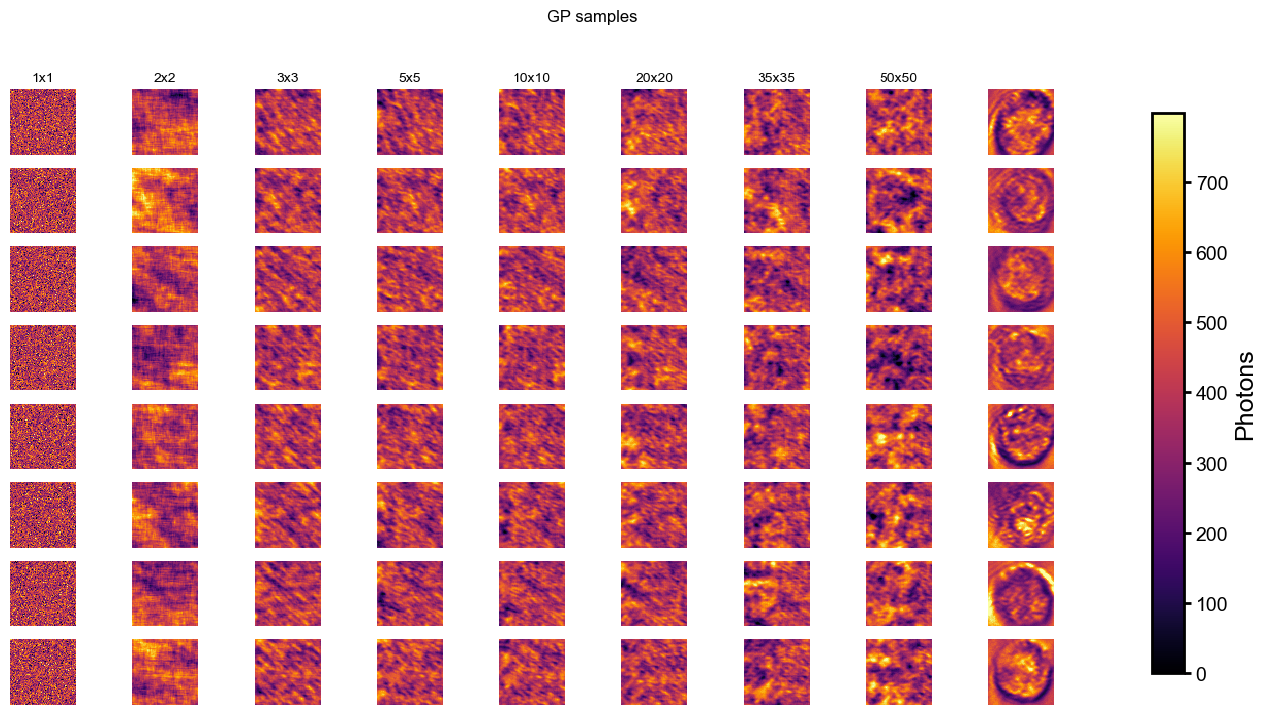

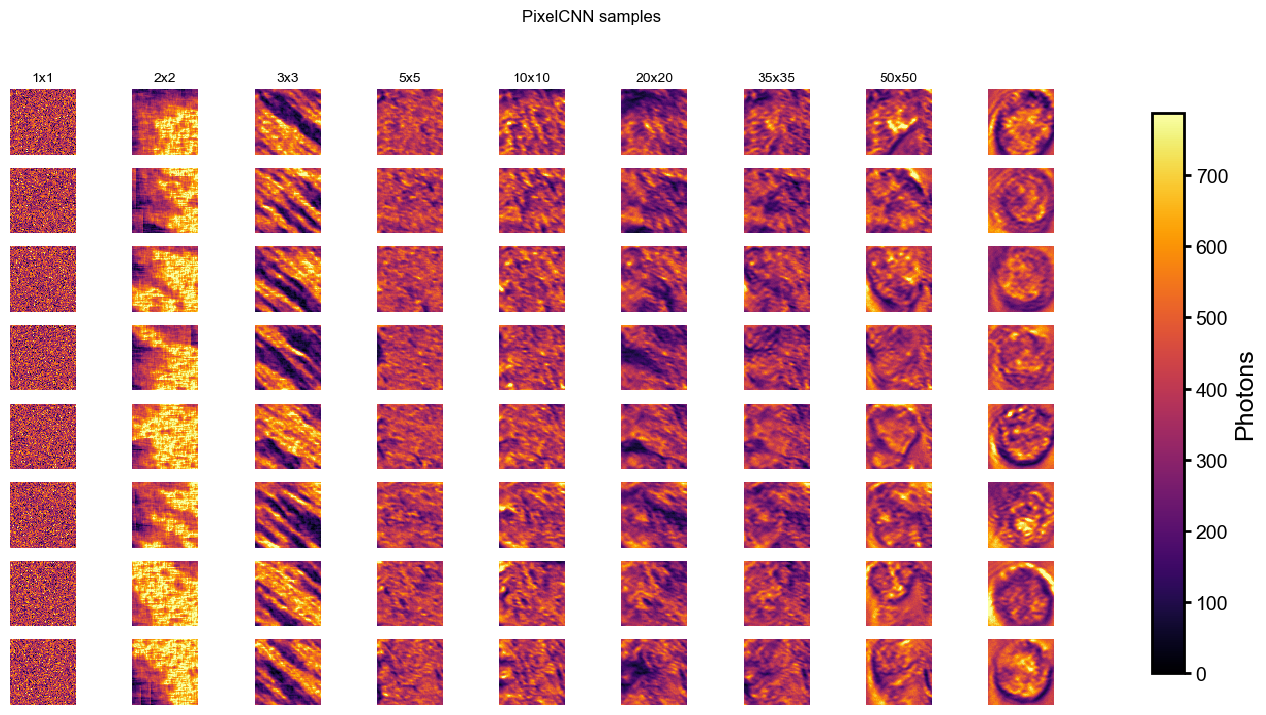

In [4]:
for model_name in ['GP', 'PixelCNN']:
    fig, axs = plt.subplots(num_samples, len(patch_sizes) + 1, figsize=( len(patch_sizes) * 2, num_samples ), sharex=True, sharey=True)
    vmin, vmax = None, None
    for j, patch_size in enumerate(patch_sizes):
        model_samples_for_patch_size = samples[patch_sizes[j]][model_name]
        if vmin is None:
            vmin, vmax = np.percentile(model_samples_for_patch_size, .1), np.percentile(model_samples_for_patch_size, 99.9)
        for i in range(num_samples):
            im = axs[i, j].imshow(model_samples_for_patch_size[i], cmap='inferno', vmin=vmin, vmax=vmax, interpolation='none')
            axs[i, j].axis('off')

    # show ground truth patch
    display_patches = extract_patches(images, sample_size, num_patches=num_samples, seed=7)
    for i in range(num_samples):
        axs[i, -1].imshow(display_patches[i], cmap='inferno', vmin=vmin, vmax=vmax, interpolation='none')
        axs[i, -1].axis('off')

    # add colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    cbar_ax.set_ylabel('Photons')

    # add a label to each col
    for j, patch_size in enumerate(patch_sizes):
        axs[0, j].set_title(f'{patch_size}x{patch_size}', fontsize=10)
    fig.suptitle(f'{model_name} samples', fontsize=12)

/tmp/ipykernel_17505/3972993745.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=[''] + [f'{ps}x{ps}' for ps in np.arange(10, 51, 10)], xticks=np.arange(0, 51, 10))


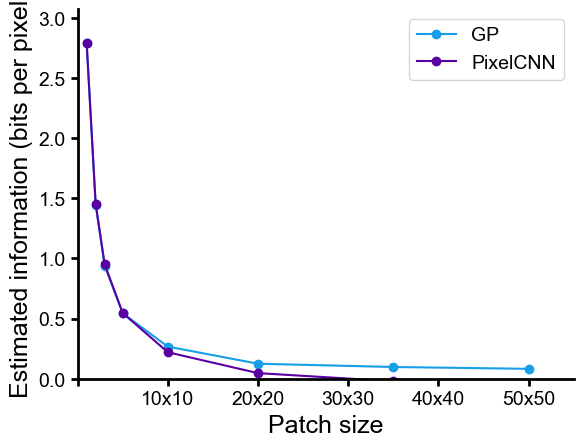

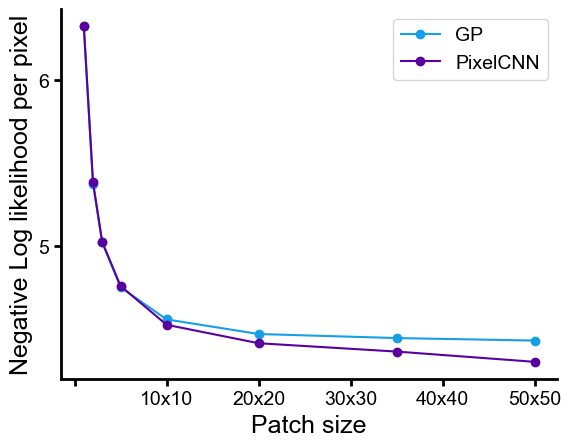

In [5]:
from matplotlib.ticker import MaxNLocator

# Mutual information vs patch size
fig, ax = plt.subplots()
ax.plot(patch_sizes, [mi_estimates_gp[ps] for ps in patch_sizes], 'o-', label='GP')
ax.plot(patch_sizes, [mi_estimates_pixel_cnn[ps] for ps in patch_sizes], 'o-', label='PixelCNN')
clear_spines(ax)
ax.set(xlabel='Patch size', ylabel='Estimated information (bits per pixel)', ylim=[0, 1.1 * 
                        max(max(mi_estimates_gp.values()), max(mi_estimates_pixel_cnn.values()))  ],
        xlim=[0, 1.1 * max(patch_sizes)], xticks=np.arange(0, 51, 10))
ax.set(xticklabels=[''] +[f'{ps}x{ps}' for ps in np.arange(10, 51, 10)])
ax.legend()

fig, ax = plt.subplots()
nll_per_pixel_gp = [test_set_NLL_gp[ps] for ps in patch_sizes]
nll_per_pixel_pixel_cnn = [test_set_NLL_pixel_cnn[ps] for ps in patch_sizes]

ax.plot(patch_sizes, nll_per_pixel_gp, 'o-', label='GP')
ax.plot(patch_sizes, nll_per_pixel_pixel_cnn, 'o-', label='PixelCNN')

clear_spines(ax)
ax.set(xlabel='Patch size', ylabel='Negative Log likelihood per pixel')
ax.set(xticklabels=[''] + [f'{ps}x{ps}' for ps in np.arange(10, 51, 10)], xticks=np.arange(0, 51, 10))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
